# Create media designs using Latin Hypercube for LCMS flaviolin experiment

This notebook generates a set of media designs using Latin Hypercube sampling. We use ART's capability to provide this kind of designs for media components for which to get phenotypic data. We will use two types of assays for this experiment - absorbance at 340nm and LCMS measurements.  


We include a design that is very close to the standard media (up to 5% variation for each component), as a control for every cycle.

Tested using **ART 3.9.4** kernel on jprime.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds.csv`
- `standard_recipe_concentrations.csv`

**File generated by running this notebook**
- `recommendations_initial.csv`

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
sys.path.append('../')
import re
import warnings
 
import matplotlib.pyplot as plt

from art.core import * 
import art.plot as plot
import edd_utils as eddu
from core import designs_pairwise


## User parameters

### Defining media components and the number of instances (designs) to be created

In [2]:
CYCLE = 6

user_params = {
    'bounds_file': f'../data/flaviolin/Putida_media_bounds.csv',
    'output_file_path': f'../data/flaviolin/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../data/flaviolin/standard_recipe_concentrations.csv',
}

Specify which components to explore:

In [3]:
user_params['components'] = [
    'H3BO3',
    'K2SO4',
    'K2HPO4',
    'FeSO4',
    'NH4Cl',
    'MgCl2',
    'NaCl',
    '(NH4)6Mo7O24',
    'CoCl2',
    'CuSO4',
    'MnSO4',
    'ZnSO4'
]

Here we specify how many instances (designs) we want to create and how many replicates (change as desired). In this case we run two DBTL cycles with initial designs, 12 instances with 4 replicates for each, out of which one design is reserved for the control.

In [4]:
user_params['n_instances'] = 15
user_params['n_replicates'] = 3 

In [5]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

In [6]:
df_stand

,Concentration[mM],Solubility[mM]
Component,,
MOPS,40.00000,2389.37
Tricine,4.00000,500.08
H3BO3,0.00400,700.00
Glucose,20.00000,5045.63
K2SO4,0.29000,636.98
K2HPO4,1.32000,8564.84
FeSO4,0.01000,1645.73
NH4Cl,9.52000,6543.28
MgCl2,0.52000,569.27


### Generate the control media 

Control media will be uniformly drawn from the interval 90% to 110% around the standard recipe.

In [7]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at[0, component] = stand_conc*np.random.uniform(lb, ub)


In [11]:
df_control

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
0,0.003968,0.278836,1.196387,0.010759,10.408408,0.475231,51.20097,0.000028,0.000316,0.000091,0.000777,0.000103


In [8]:
df_control.loc[0] = np.array(
    [0.003968, 
     0.278836,
     1.196387,
     0.010759,
     10.408408,
     0.475231,
     51.20097,
     0.000028,
     0.000316,
     0.000091,
     0.000777,
     0.000103]
)

### Generate random media

Define a dictionary that contains the settings that ART will use to find the recommended designs:

In [7]:
art_params = {
    'input_vars': user_params['components'],  # input variables, i.e. features
    'bounds_file': user_params['bounds_file'],  # file with bounds
    'num_recommendations': user_params['n_instances'],   
    'initial_cycle': True,                                    # Set this to True for initial designs recommendations
    'seed': 10,                                               # seed for number random generator
    'output_directory': user_params['output_file_path']  # directory to store this output
}


With the configuration stored in `art_params`, we now run ART:

In [10]:
art = RecommendationEngine(**art_params)
df = art.recommendations.copy()
df.tail()

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
10,0.011667,2.882740,0.995188,0.090655,10.324943,1.933593,189.206250,0.000157,0.000048,0.000507,0.002133,0.000588
11,0.021833,0.405193,0.424550,0.045675,7.721296,3.019698,136.129853,0.000142,0.002977,0.000726,0.006938,0.000415
12,0.007477,1.365148,3.268669,0.097711,10.965631,0.771413,391.274625,0.000066,0.001611,0.000809,0.006266,0.000899
13,0.034219,0.487692,5.964381,0.078645,9.187989,2.424902,103.608502,0.000248,0.001288,0.000352,0.000772,0.000867
14,0.002513,0.691736,2.092997,0.061301,9.694639,1.242139,147.653638,0.000061,0.000376,0.000416,0.003509,0.000269


In [11]:
df_target = df.copy()
df_target = df_target.append(df_control).reset_index(drop=True)
df_target

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
0,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.00095,0.004621,0.000744
1,0.008628,0.896852,5.044414,0.017022,13.269195,2.52172,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
2,0.01668,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363
3,0.039421,2.139989,6.48219,0.004907,8.404625,1.63091,409.900003,0.000029,0.000997,0.000322,0.000492,0.0003
4,0.003822,2.110887,4.828971,0.054005,12.426865,3.494197,309.231334,0.000193,0.001809,0.00002,0.004225,0.00049
5,0.019247,0.063172,5.616681,0.071373,8.774074,0.114856,486.966008,0.000276,0.002404,0.000233,0.00758,0.000716
6,0.014314,1.389174,3.018874,0.03269,11.53211,3.145739,66.174686,0.000219,0.00109,0.000193,0.007039,0.000647
7,0.03157,1.171567,2.755917,0.039552,12.915469,0.694204,347.206468,0.000167,0.002186,0.000782,0.003175,0.000109
8,0.03717,2.57281,1.415232,0.026265,14.070721,4.071614,286.626122,0.000286,0.000589,0.000105,0.00532,0.000975
9,0.027296,1.86347,1.870718,0.051378,12.142509,4.286369,441.442899,0.000005,0.002629,0.000664,0.005428,0.000175


### Checking the distribution of initial designs

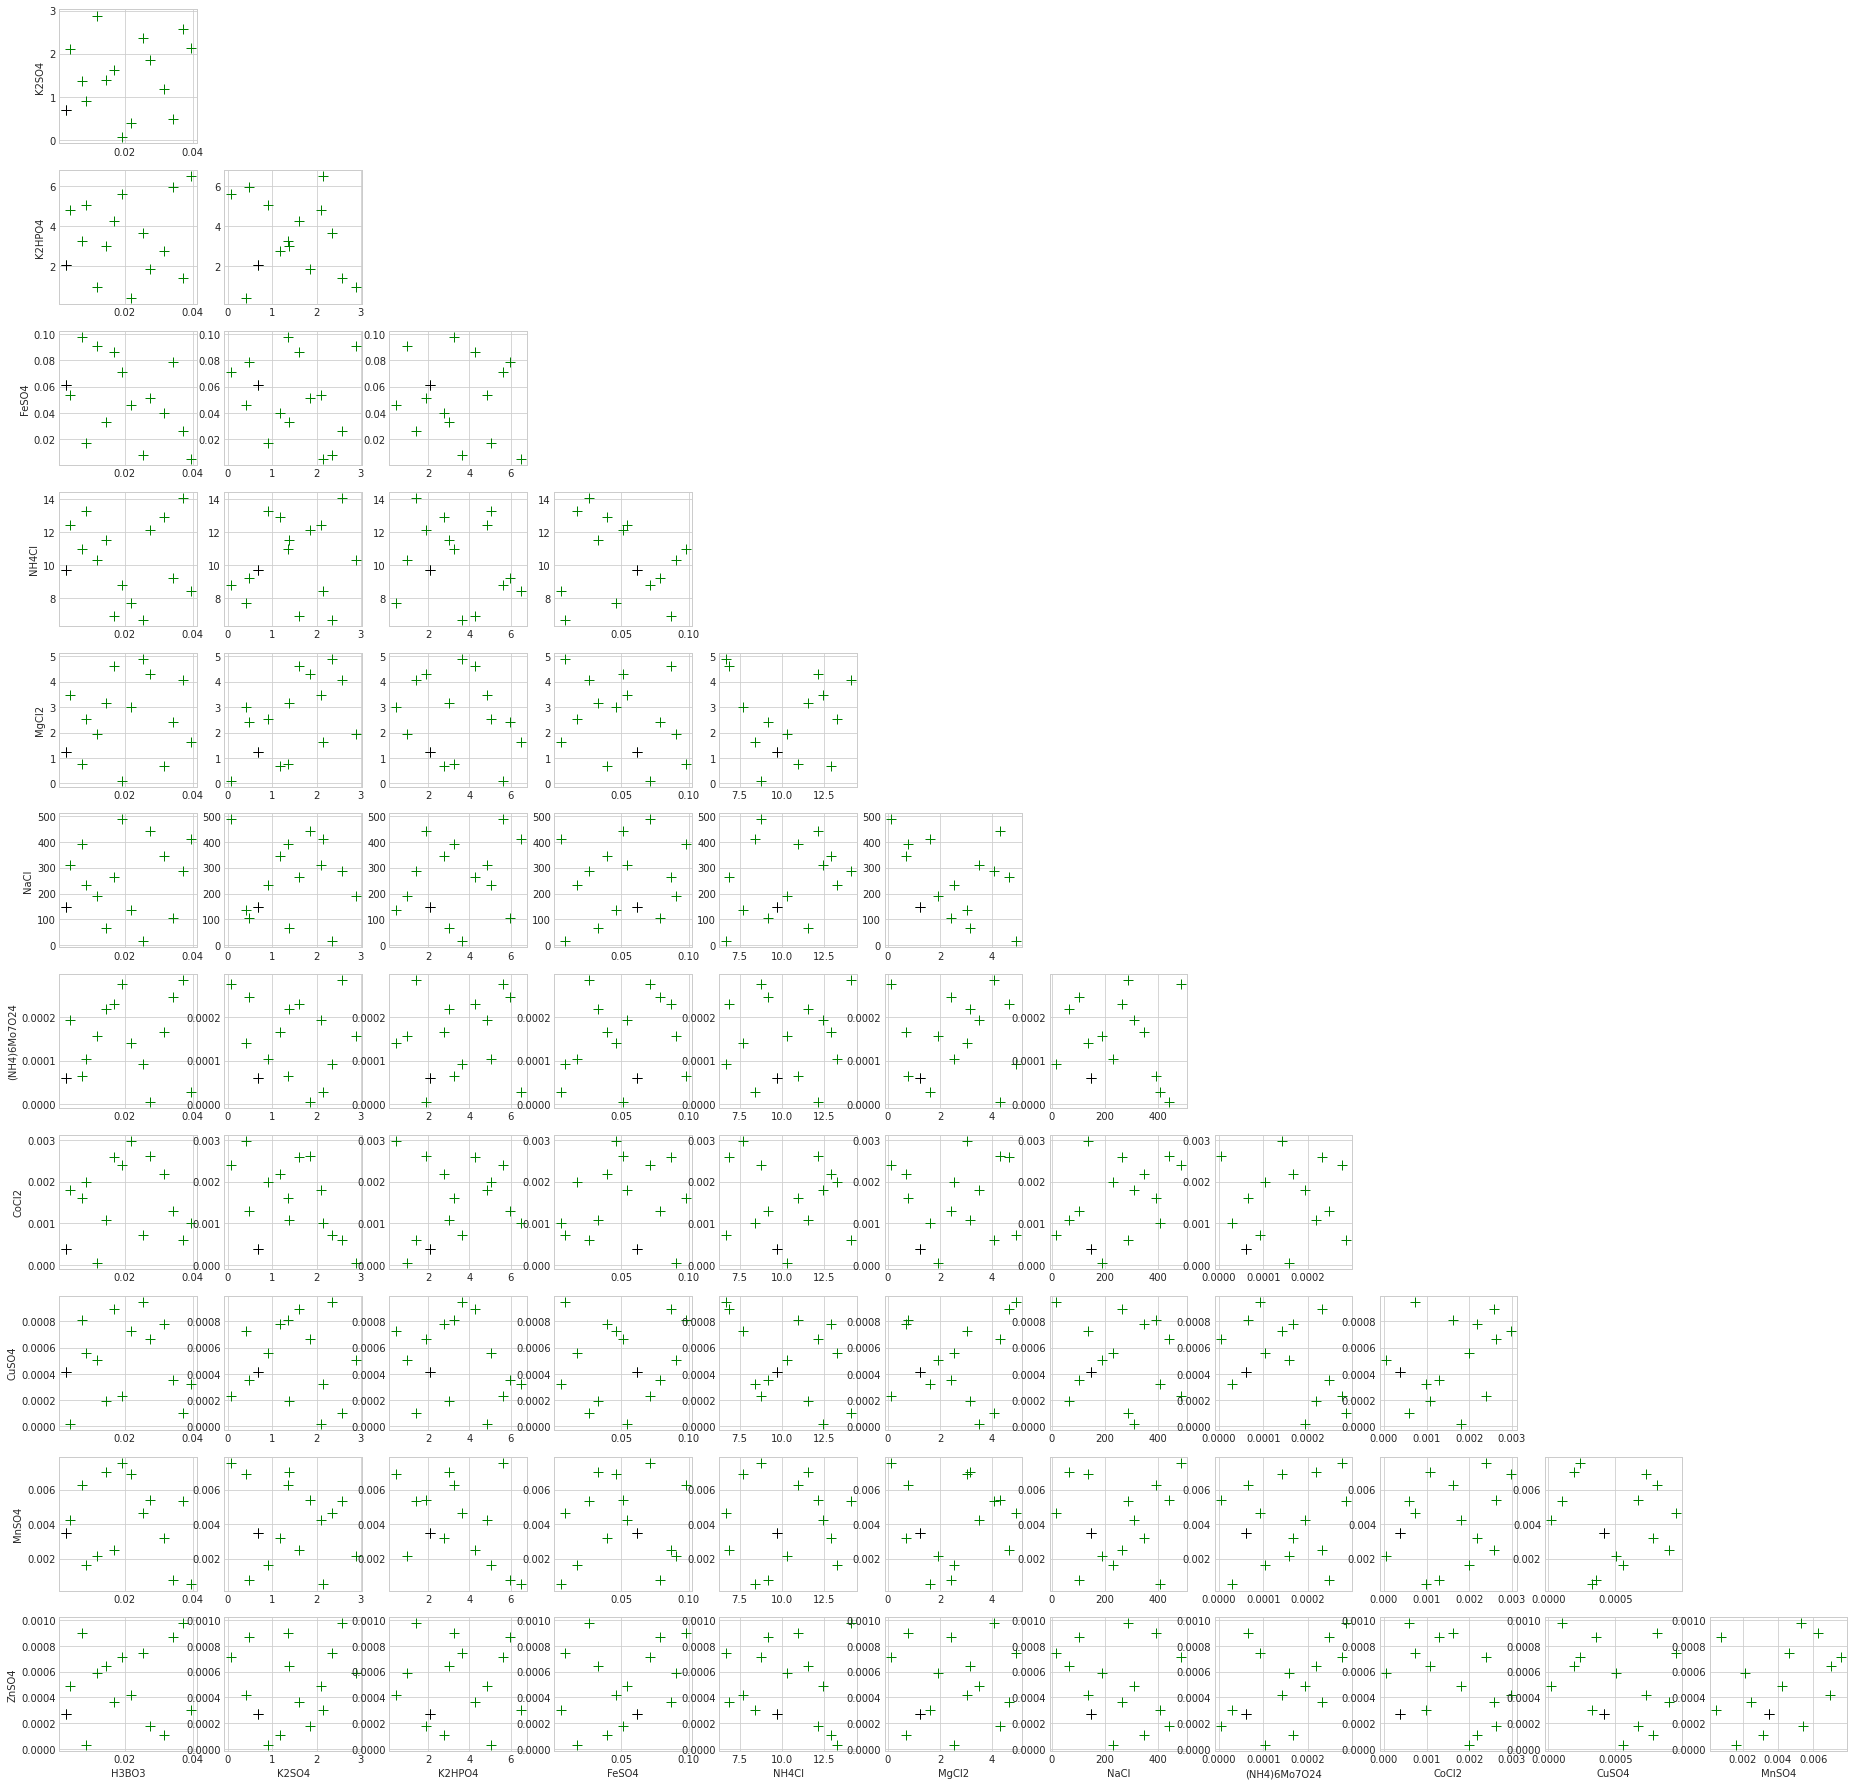

In [12]:
designs_pairwise(art, df, user_params, initial=True)

## Saving the generated designs

Include all replicates: 

In [13]:
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]


Rename index to well names:

In [14]:
well_rows = 'ABCDEF'
well_columns = '12345678'

In [15]:
well_names = [f'{row}{column}' for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
Well,,,,,,,,,,,,
A1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.00095,0.004621,0.000744
B1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.00095,0.004621,0.000744
C1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.00095,0.004621,0.000744
D1,0.008628,0.896852,5.044414,0.017022,13.269195,2.52172,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
E1,0.008628,0.896852,5.044414,0.017022,13.269195,2.52172,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
F1,0.008628,0.896852,5.044414,0.017022,13.269195,2.52172,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
A2,0.01668,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363
B2,0.01668,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363
C2,0.01668,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363


In [16]:
file = f"{user_params['output_file_path']}/target_concentrations.csv"
df_target.to_csv(file)

## Train ART on all previous data (DBTL 1-5)

In [7]:
user_params['study_slug_1'] = 'combinatorial-media-for-flaviolin-dbtl1-ed1e'
user_params['study_slug_2'] = 'combinatorial-media-for-flaviolin-dbtl-2'
user_params['study_slug_3'] = 'combinatorial-media-for-flaviolin-dbtl-3'
user_params['study_slug_4'] = 'combinatorial-media-for-flaviolin-dbtl-4'
user_params['study_slug_5'] = 'combinatorial-media-for-flaviolin-dbtl-5'

user_params['edd_server'] = 'edd.jbei.org'
user_params['username'] = 'tradivojevic'

user_params['response'] = 'OD340'

## Load the data

In [9]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']
study_slug_3 = user_params['study_slug_3']
study_slug_4 = user_params['study_slug_4']
study_slug_5 = user_params['study_slug_5']
edd_server = user_params['edd_server']
username = user_params['username']

In [10]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for tradivojevic:  ··············


OK! Connection to EDD successful. We will try to load data from EDD...


In [13]:
warnings.filterwarnings("ignore")

In [14]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    df_3 = eddu.export_study(session, study_slug_3, edd_server=edd_server)
    df_4 = eddu.export_study(session, study_slug_4, edd_server=edd_server)
    df_5 = eddu.export_study(session, study_slug_5, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Concatenate the five studies:

In [15]:
df = df_1.append(df_2).append(df_3).append(df_4).append(df_5)

Drop unnecessary columns:

In [16]:
df = df.loc[:,['Line Name','Line Description','Protocol','Value']]
df.head()

,Line Name,Line Description,Protocol,Value
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4422
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3405
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3397
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3602
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.2699


Pivot the dataframe to include columns for all protocols:

In [17]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Protocol", values="Value")
df.reset_index(inplace=True)
df.head()

Protocol,Line Name,Line Description,OD340,OD600
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.4422,2.019
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3405,0.516
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3397,0.436
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3602,0.623
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.2699,0.699


### Adding media information to the data frame

Add columns for each component:

In [18]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None


And assign values for each component and line:

In [19]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (4+c)] = float(value)

df.drop(columns='Line Description', inplace=True)
df.tail()

Protocol,Line Name,OD340,OD600,MOPS,Tricine,H3BO3,Glucose,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
235,C5_WD7_F7-R2,0.6091,0.708,40.0,4.0,0.037489,20.0,2.431795,5.052745,0.058807,9.155386,2.372341,361.921617,0.00028,0.002575,0.000967,0.004346,0.000037
236,C5_WD7_F7-R3,0.6303,0.445,40.0,4.0,0.037489,20.0,2.431795,5.052745,0.058807,9.155386,2.372341,361.921617,0.00028,0.002575,0.000967,0.004346,0.000037
237,C5_WD8_F8-R1,0.2476,1.469,40.0,4.0,0.004112,20.0,0.261299,1.194531,0.01038,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109
238,C5_WD8_F8-R2,0.2498,1.283,40.0,4.0,0.004112,20.0,0.261299,1.194531,0.01038,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109
239,C5_WD8_F8-R3,0.2316,0.863,40.0,4.0,0.004112,20.0,0.261299,1.194531,0.01038,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109


Define the control lines. In DBTL 1 and 2, controls were wells F5 to F8. In DBTL 3 is stored in the last column (D8, E8, F8).

In [20]:
control_lines = df[df['Line Name'].str.find('WF5_F8') > 0]

control_lines = control_lines.append(df[df['Line Name'].str.find('WD8_F8') > 0])

In [19]:
control_lines

Protocol,Line Name,OD340,OD600,MOPS,Tricine,H3BO3,Glucose,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
44,C1_WF5_F8-R1,0.2856,0.731,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102
45,C1_WF5_F8-R2,0.2936,0.763,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102
46,C1_WF5_F8-R3,0.2715,0.664,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102
47,C1_WF5_F8-R4,0.2891,0.795,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102
92,C2_WF5_F8-R1,0.2934,0.631,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
93,C2_WF5_F8-R2,0.2912,0.593,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
94,C2_WF5_F8-R3,0.3004,0.601,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
95,C2_WF5_F8-R4,0.2990,0.671,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
141,C3_WD8_F8-R1,0.2813,1.022,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098
142,C3_WD8_F8-R2,0.2755,0.800,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098


How many designs improve response over the standard recipe?

In [21]:
control_response = np.max(control_lines['OD340'])
num_improved_response = np.sum(df['OD340'] > control_response)
num_designs = len(df) - len(control_lines)
print(f'{num_improved_response} samples out of {num_designs} improve over the standard in terms of OD340 ({num_improved_response/num_designs*100:.2f}%).')


184 samples out of 223 improve over the standard in terms of OD340 (82.51%).


### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [22]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']
df_stacked.head()

,Line Name,Measurement Type,Value
0,C1_WA1_A4-R1,OD340,0.4422
1,C1_WA1_A4-R1,OD600,2.019
2,C1_WA1_A4-R1,MOPS,40.0
3,C1_WA1_A4-R1,Tricine,4.0
4,C1_WA1_A4-R1,H3BO3,0.003744


### ART training

Define a dictionary that contains the settings that ART will use to generate a predictive model:

In [8]:
art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds_file': user_params['bounds_file'], # file with bounds# input variables, i.e. features
    'seed': 10,                                           # seed for number random generator
    'cross_val': False,
    'recommend': False,
    'output_directory': user_params['output_file_path'],  # directory to store this output
    'verbose': 1,
#     'max_mcmc_cores': 2
}

With the configuration stored in art_params, we now run ART:

In [10]:
run_art = False

In [11]:
%%time
if run_art:
    art = RecommendationEngine(df_stacked, **art_params)
else:
    with open(os.path.join(art_params['output_directory'], 'art.pkl'), 'rb') as output:
        art = pickle.load(output)

/usr/local/share/jupyteruser/miniconda3/envs/ART_3.9.4/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


CPU times: user 1.54 s, sys: 171 ms, total: 1.71 s
Wall time: 5.66 s


In [26]:
# art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.141671,40.030865,0.102689,0.030616,-0.490968
Random Forest Regressor,0.054718,15.390518,0.052298,0.005729,0.720990
TPOT Regressor,0.056075,15.435011,0.043705,0.005054,0.753850
Support Vector Regressor,0.085332,24.854194,0.053014,0.010092,0.508520
Kernel Ridge Regressor,0.105712,25.906211,0.082420,0.017968,0.124964
K-NN Regressor,0.081428,23.473636,0.075495,0.012330,0.399535
Gaussian Process Regressor,0.084277,23.680166,0.057482,0.010407,0.493194
Gradient Boosting Regressor,0.054837,15.401393,0.048411,0.005351,0.739425
Ensemble Model,0.055939,15.399486,0.044817,0.005138,0.749794


### Check the distribution of designs

Define dataframe with train data and predictions:

In [60]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']

Add predictions, cv-predictions and standard deviation of the OD340 predictions:

In [61]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )

In [62]:
df_train['OD340_pred'] = train_predicted_mean
df_train['OD340_std'] = train_predicted_std
df_train['OD340_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['OD340_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]

Add label for control lines:

In [63]:
df_train['Label'] = 'train'
df_train.loc[control_lines.index, 'Label'] = 'standard'

In [64]:
df_train

Protocol,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
0,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.4422,0.380331,0.061722,0.399012,0.062488,train
1,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3405,0.380331,0.061722,0.399012,0.062488,train
2,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3397,0.380331,0.061722,0.399012,0.062488,train
3,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3602,0.380331,0.061722,0.399012,0.062488,train
4,0.009185,0.380499,1.156774,0.007971,11.618192,5.030266,50.60791,0.000155,0.000152,0.000029,0.00041,0.000277,0.2699,0.272069,0.061773,0.271477,0.066630,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.032352,2.681768,6.293779,0.003636,13.0573,1.67801,433.346634,0.000258,0.002099,0.000391,0.007259,0.000835,0.5844,0.569786,0.061782,0.470041,0.053597,train
188,0.032352,2.681768,6.293779,0.003636,13.0573,1.67801,433.346634,0.000258,0.002099,0.000391,0.007259,0.000835,0.5646,0.569786,0.061782,0.470041,0.053597,train
189,0.003932,0.309966,1.206566,0.01076,9.146237,0.502864,52.253707,0.00003,0.000304,0.0001,0.000726,0.000098,0.2745,0.280968,0.061725,0.276981,0.070134,standard
190,0.003932,0.309966,1.206566,0.01076,9.146237,0.502864,52.253707,0.00003,0.000304,0.0001,0.000726,0.000098,0.2829,0.280968,0.061725,0.276981,0.070134,standard


Save train data set for this cycle:

In [65]:
file = f"{user_params['output_file_path']}/train_pred.csv"
df_train.to_csv(file)

In [66]:
def designs_pairwise(art, df_rec, user_params, df_train=None):

    dim = art.num_input_var

    plt.style.use('seaborn-whitegrid')

    fig = plt.figure(figsize=(35, 35))
    fig.patch.set_facecolor("white")

    X = df_rec[user_params['components']].values
    X_train = df_train[user_params['components']].values
    standard = df_train[df_train['Label']=='standard'].drop(columns='Label').values

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            ax.scatter(
                X_train[:, var1],
                X_train[:, var2],
                c="r",
                marker="+",
                s=150*df_train['OD340'],
                lw=1,
                label="Train data",
            )
            
            ax.scatter(
                standard[:, var1],
                standard[:, var2],
                c="k",
                marker="+",
                s=150*standard[:, -1].astype(float),
                lw=1,
                label="Standard",
            )
            
            ax.scatter(
                X[:, var1],
                X[:, var2],
                c="g",
                marker="+",
                s=150*df_rec['OD340_pred'],
                lw=1,
                label="Recommendations",
            )
            
            ax.scatter(
                X[-1, var1],
                X[-1, var2],
                c="k",
                marker="+",
                s=150*df_rec['OD340_pred'].values[-1],
                lw=1,
                label="Standard",
            )
            
            
                        
            if var2 == (dim - 1):
                ax.set_xlabel(art.input_vars[var1])
            if var1 == 0:
                ax.set_ylabel(art.input_vars[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

    fig.savefig(
        f'{art.outDir}/designs_pairwise.png',
        bbox_inches="tight",
        transparent=False, 
        dpi=300
    )

Red are train data, green are recommendations, black are standards

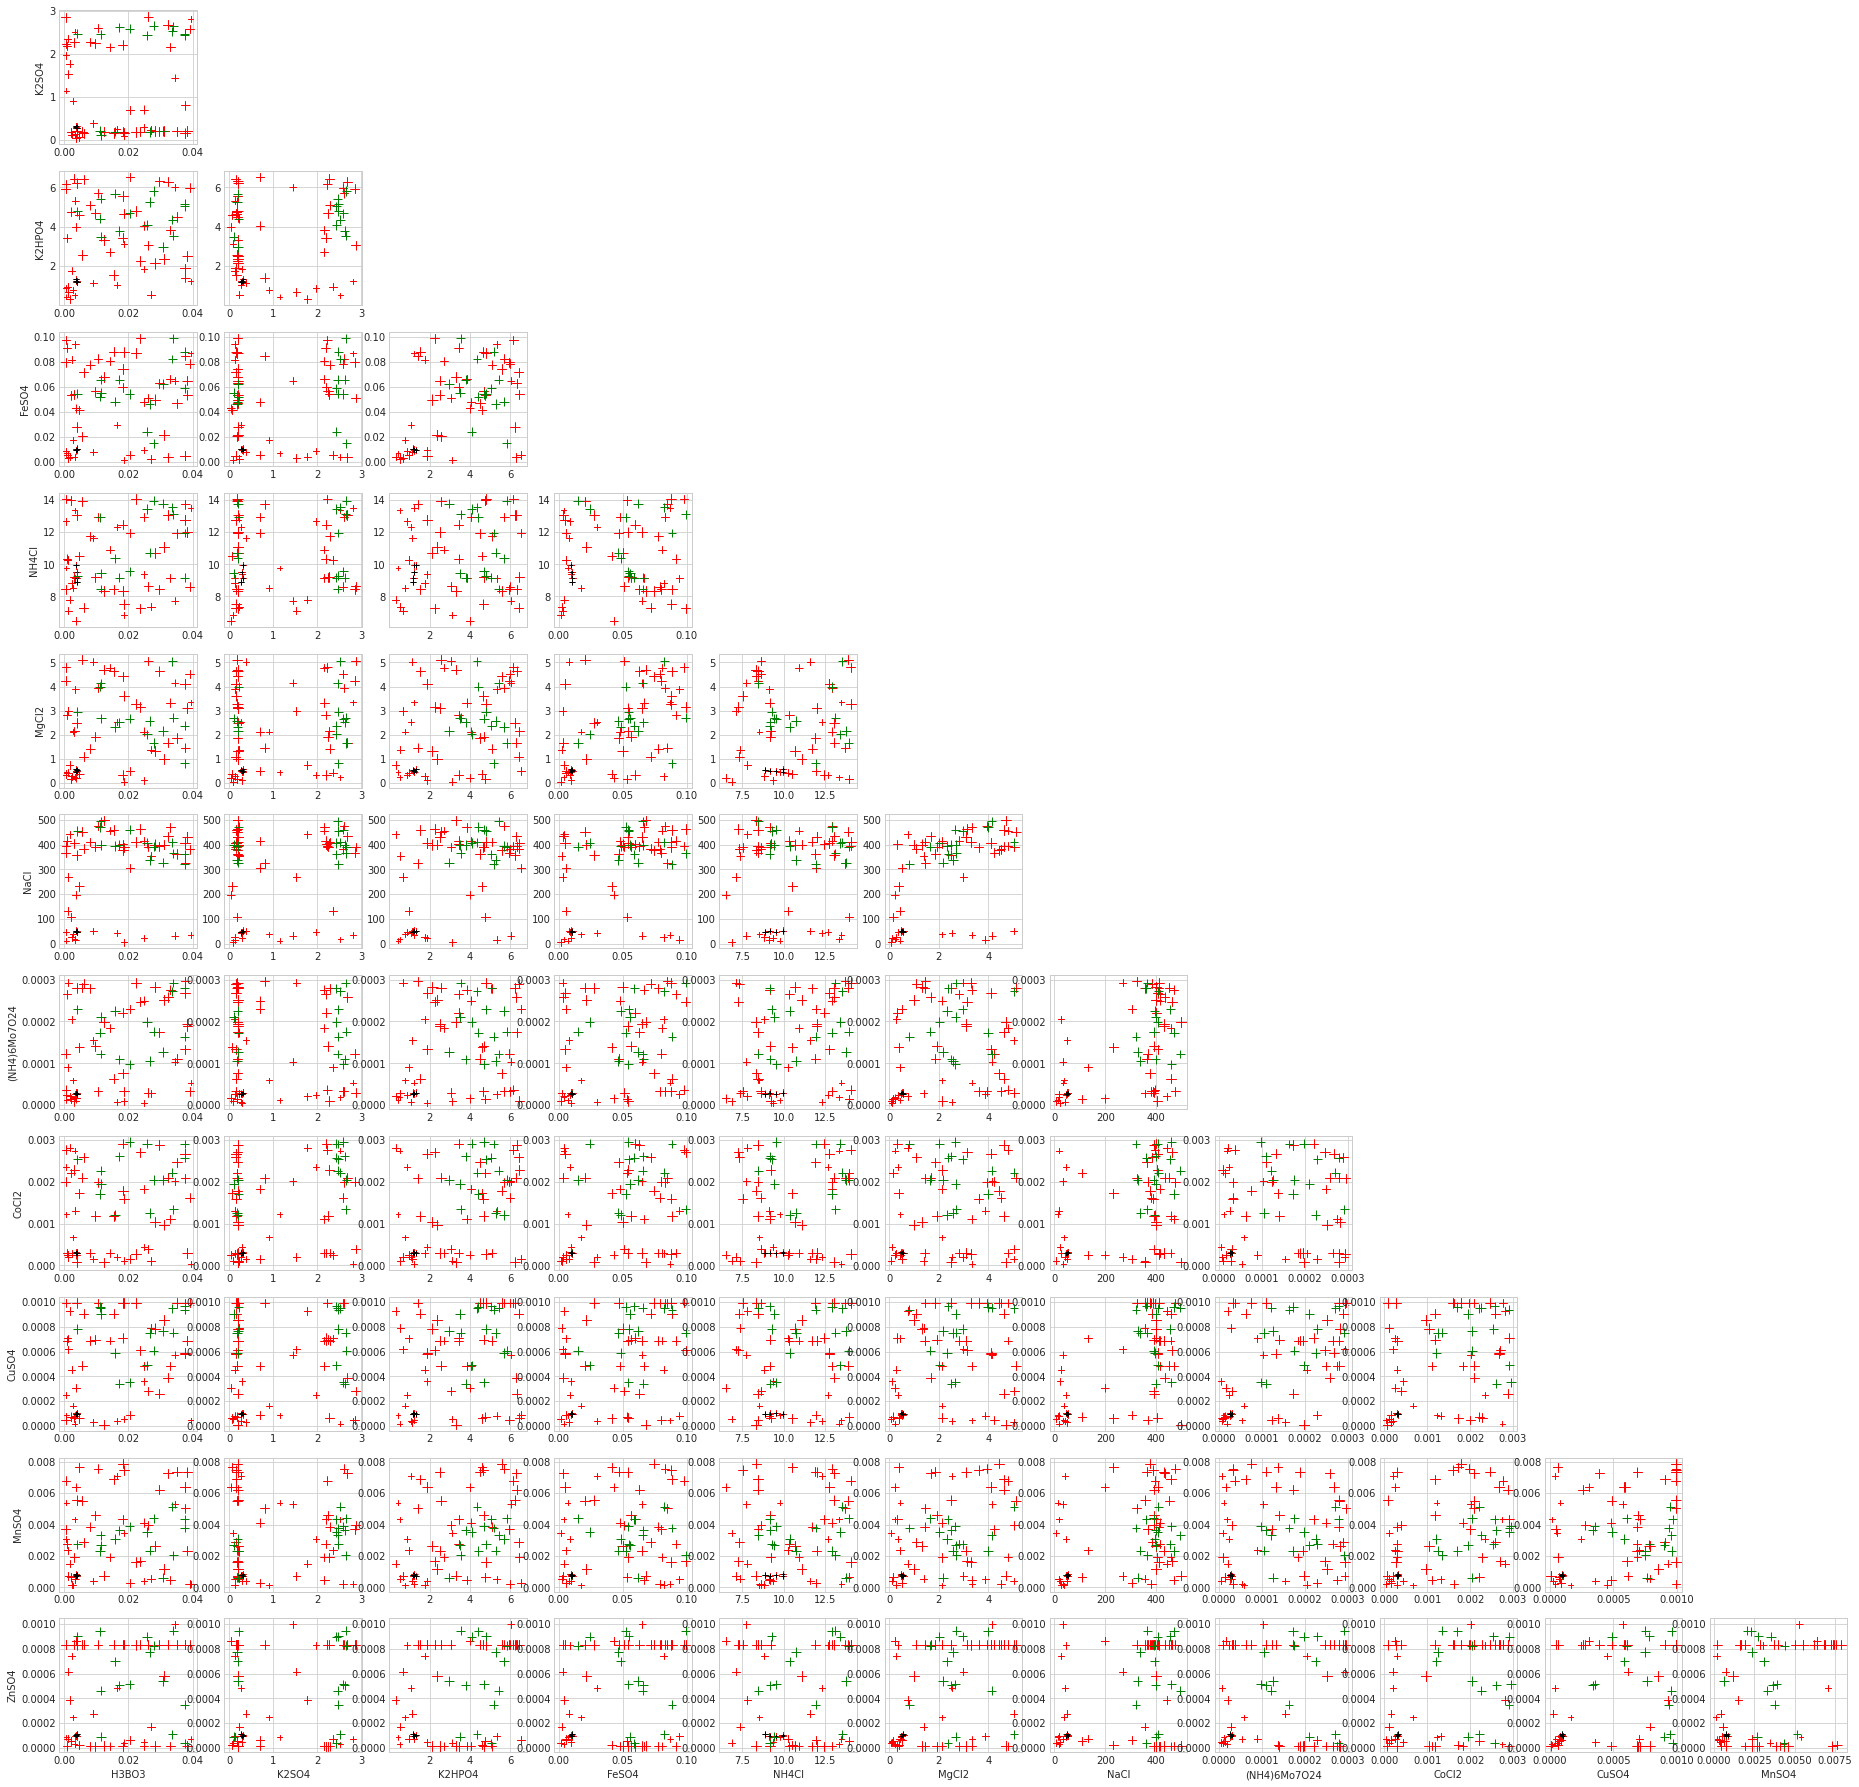

In [68]:
designs_pairwise(art, df_rec, user_params, df_train)

## Explaining ART model with Shapley values

Shapley values are a widely used approach from cooperative game theory that come with desirable properties. 

In [13]:
import shap

from sklearn.model_selection import train_test_split
shap.initjs()

Define the function for our predictions:

In [14]:
def f(X):
    return art.predict(X)

In [15]:
X_df = pd.DataFrame(data=art.X, columns=user_params['components'])

In [17]:
explainer_e = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

Permutation explainer: 241it [45:42, 11.43s/it]                         


The core idea behind Shapley value based explanations of machine learning models is to use fair allocation results from cooperative game theory to allocate credit for a model's output $f(x)$ among its input features.

- Get all subsets that don’t contain the feature $i$
- Find the marginal contribution of the feature $i$ to each of these subsets
- Aggregate all marginal contributions to compute the contributions of the feature $i$
- For each of these subsets, SHAP doesn’t remove a feature then retrain the model but replaces that feature with the average value of that feature, then generates the predictions.

When we are explaining a prediction $f(x)$, the SHAP value for a specific feature $i$ is just the difference between the expected model output and the partial dependence plot at the feature's value $x_i$.

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


ValueError: x and y can be no greater than 2D, but have shapes (2,) and (2, 1, 1)

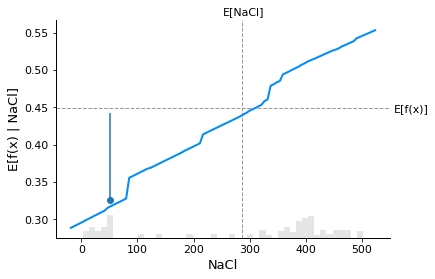

In [26]:
sample_ind = 5

# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "NaCl", f, X_df, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_e[sample_ind:sample_ind+1, :]
)


One the fundemental properties of Shapley values of all the input features is that they always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

**Local bar plot**

How much did each feature contribute to the difference between the final prediction and the average prediction?

Passing a row of SHAP values to the bar plot function creates a local feature importance plot, where the bars are the SHAP values for each feature. 

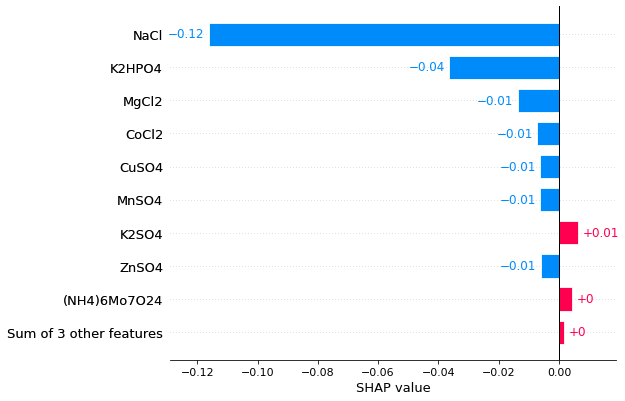

In [47]:
shap.plots.bar(shap_values_e[sample_ind])

Passing a matrix of SHAP values to the bar plot function creates a **global** feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

By default a SHAP bar plot will take the mean absolute value of each feature over all the instances of the dataset.

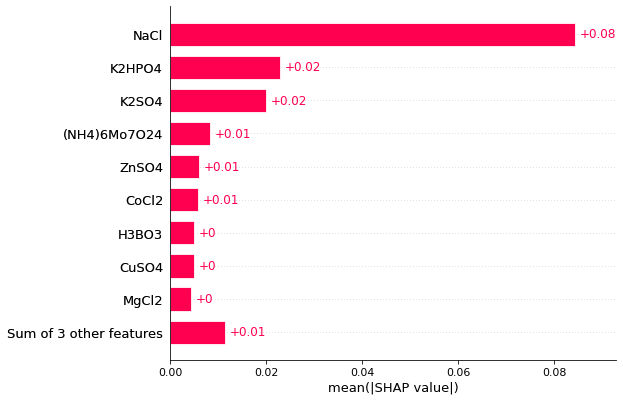

In [49]:
shap.plots.bar(shap_values_e)

But the mean absolute value is not the only way to create a global measure of feature importance, we can use any number of transforms. Here we show how using the max absolute value places MgCl2 as the 4th feature

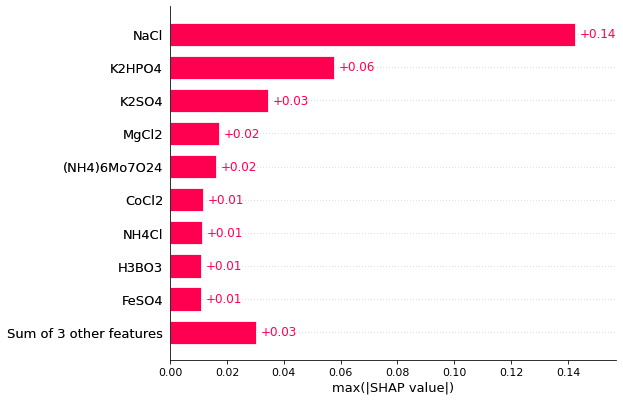

In [48]:
shap.plots.bar(shap_values_e.abs.max(0))

To inspect the global importance of each feature in the model for all instances we run:

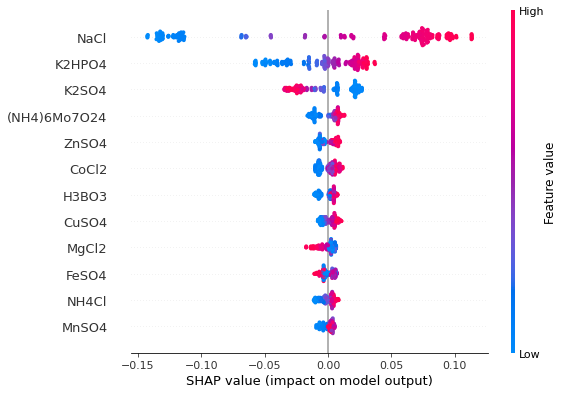

In [51]:
shap.summary_plot(shap_values_e)


This bar plot shows that NaCl, K2HPO4, K2SO4 are the top three factors driving the model's prediction of OD340

Passing a matrix of SHAP values to the heatmap plot function creates a plot with the instances on the x-axis, the model inputs on the y-axis, and the SHAP values encoded on a color scale. By default the samples are ordered using shap.order.hclust, which orders the samples based on a hierarchical clustering by their explanation similarity. This results in samples that have the same model output for the same reason getting grouped together.

The output of the model is shown above the heatmap matrix (centered around the explaination's .base_value), and the global importance of each model input shown as a bar plot on the right hand side of the plot (by default this is the shap.order.abs.mean measure of overall importance).

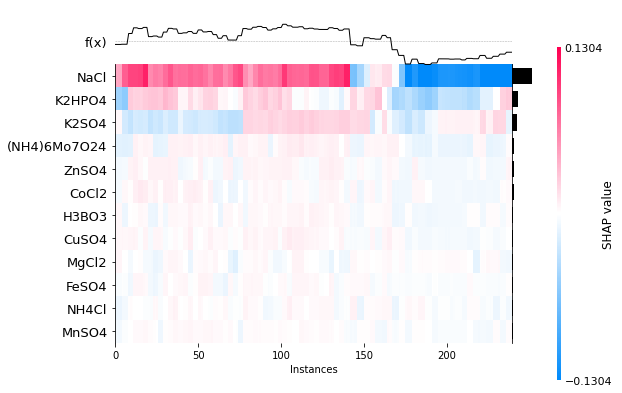

In [52]:
shap.plots.heatmap(shap_values_e, max_display=12)

We can also control the ordering of the instances using the instance_order parameter. By default it is set to shap.Explanation.hclust(0) to group samples with similar explantions together. We can also sort by the sum of the SHAP values over all features:

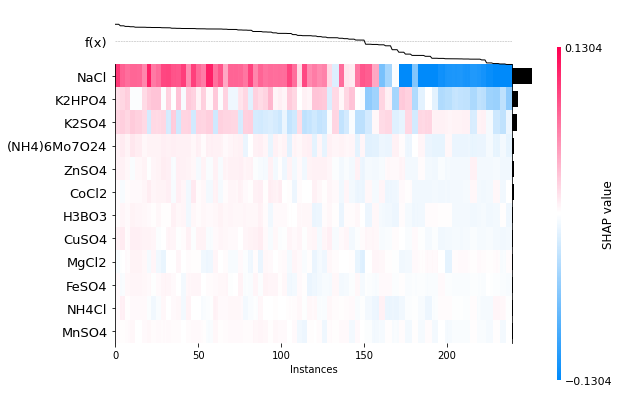

In [53]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=12)

In [57]:
shap_values_e

.values =
array([[-0.00724164,  0.02118253,  0.00815847, ..., -0.00317589,
         0.0012998 ,  0.00410397],
       [-0.00727274,  0.0213399 ,  0.00818034, ..., -0.00318415,
         0.00145423,  0.00398573],
       [-0.00729857,  0.02127132,  0.0081687 , ..., -0.00318831,
         0.00127638,  0.00401326],
       ...,
       [-0.00515846,  0.00747673, -0.03449794, ..., -0.00574225,
        -0.00363313, -0.00678957],
       [-0.00516341,  0.00742716, -0.03453767, ..., -0.00604514,
        -0.00373112, -0.00673854],
       [-0.0051091 ,  0.00745716, -0.03469629, ..., -0.00587383,
        -0.00359567, -0.00655628]])

.base_values =
array([[0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
       [0.44197442],
    

In [58]:
shap.force_plot(base_value = shap_values_e.base_values[0],
                shap_values = shap_values_e[0][0], 
                features = X_df.iloc[0,:]
                )

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_df, art.y, test_size=0.2, random_state=42)

In [96]:
# use Kernel SHAP to explain the ART's predictions
explainer = shap.KernelExplainer(model=f, data=X_train)
shap_values = explainer.shap_values(X=X_test, nsamples=10) # runs ART 10 times

Using 192 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


**Explain a single prediction from the test set**

In [105]:
shap.force_plot(base_value = explainer.expected_value[0],
                shap_values = shap_values[0][0], 
                features = X_test.iloc[0,:]
                )

**Explain all the predictions in the test set**

If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [107]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test)

A summary plot is an even better way to see the relative impact of all features over the entire dataset. Features are sorted by the sum of their SHAP value magnitudes across all samples.

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high Feature 6 (NaCl) increases the predicted OD340.

Instead of looking at each individual instance, we can visualize the overall impact of these features across multiple instances using SHAP summary plot:

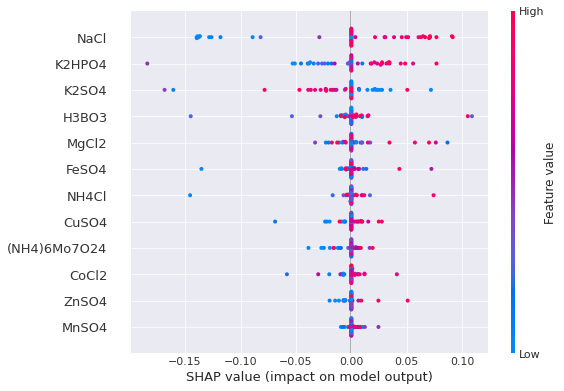

In [129]:
shap.summary_plot(shap_values=shap_values[0], features=X_test)

The SHAP summary plot tells us the most important features and their range of effects over the dataset.

Based on the above summary plot we can see that MnSO4 is the feature that have the least influence on the model and could be dropped if needed. This is the big advantage of SHAP since without this we would not have much insight into which features are actually influencing our model.

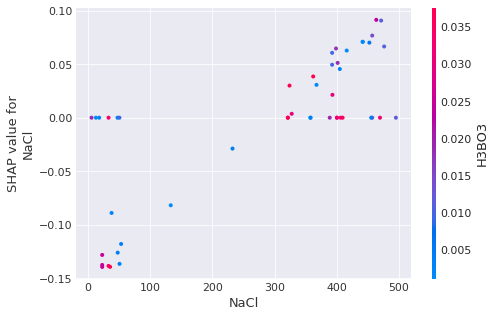

In [110]:
shap.dependence_plot("NaCl", shap_values[0], X_test)

A summary beeswarm plot is an even better way to see the relative impact of all features over the entire dataset. Features are sorted by the sum of their SHAP value magnitudes across all samples.

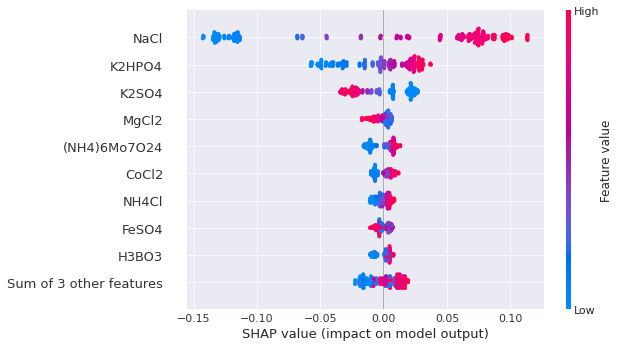

In [115]:
shap.plots.beeswarm(shap_values_e, order=shap_values_e.abs.max(0))

By taking the absolute value and using a solid color we get a compromise between the complexity of the bar plot and the full beeswarm plot. Note that the bar plots above are just summary statistics from the values shown in the beeswarm plots below.

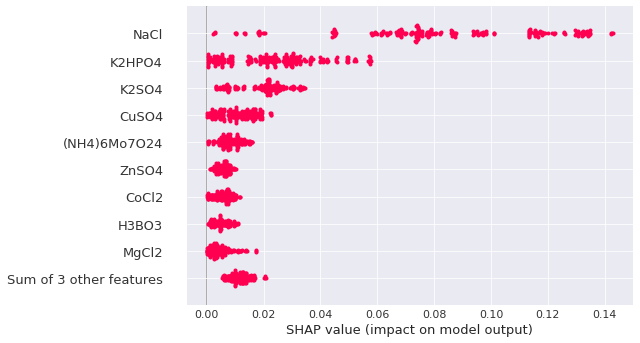

In [144]:
shap.plots.beeswarm(shap_values_e.abs, color="shap_red")

Dealing with correlated features

Using feature clustering

Often features in datasets are partially or fully redundant with each other. Where redudant means that a model could use either feature and still get same accuracy. To find these features practitioners will often compute correlation matrices among the features, or use some type of clustering method. When working with SHAP we recommend a more direct approach that measures feature redundancy through model loss comparisions. The shap.utils.hclust method can do this and build a hierarchical clustering of the feature by training XGBoost models to predict the outcome for each pair of input features. For typical tabular dataset this results in much more accurate measures of feature redundancy than you would get from unsupervised methods like correlation.


Once we compute such a clustering we can then pass it to the bar plot so we can simultainously visualize both the feature redundancy structure and the feature importances. Note that by default we don't show all of the clustering structure, but only the parts of the clustering with distance < 0.5. Distance in the clustering is assumed to be scaled roughly between 0 and 1, where 0 distance means the features perfectly redundant and 1 means they are completely independent. In the plot below we see that only relationship and marital status have more that 50% redundany, so they are the only features grouped in the bar plot:

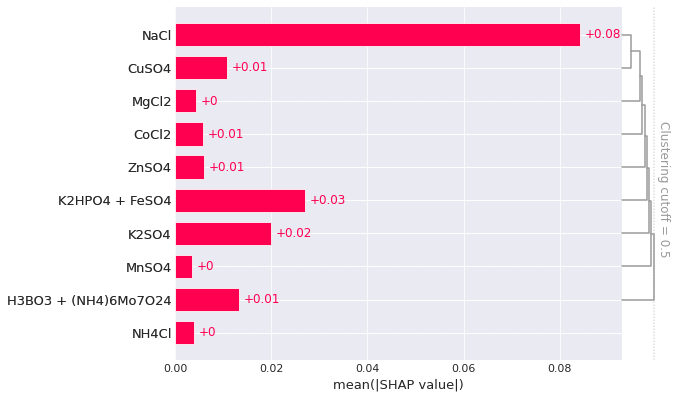

In [117]:
clustering = shap.utils.hclust(X_df, art.y) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
shap.plots.bar(shap_values_e, clustering=clustering)

IndexError: index 10 is out of bounds for axis 1 with size 1

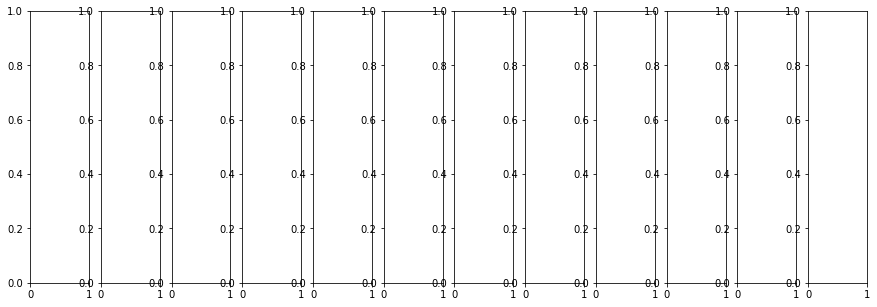

In [29]:
shap.plots.scatter(shap_values_e)

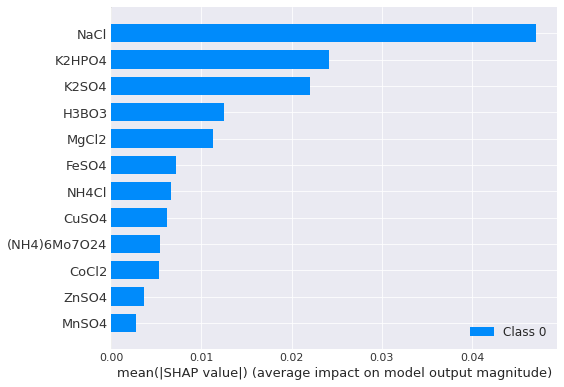

In [143]:
shap.summary_plot(shap_values_e, X_test)
